In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from cv2 import cv2 as cv
import os, pickle, shutil, json, sys
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD , Adam
import numpy as np
import random, time, collectionsd
from collections import deque
import pandas as pd
from IPython.display import clear_output
from IPython.core.display import display
import matplotlib.pyplot as plt
from PIL import Image, ImageGrab, ImageTk
import keras.applications as kapp

Using plaidml.keras.backend backend.


In [4]:
# Define variable
chrome_driver_path = "../chrome_driver/chromedriver"
# game_url = "http://localhost:8000/"
game_url = "http://hausai.com/crossyroad/"
screenshot_output = "../screenshot/input_state.png"
screenshot_path = "../screenshot/"
object_path = "../object/"

loss_file_path = "../object/loss_df.csv"
actions_file_path = "../object/actions_df.csv"
q_value_file_path = "../object/q_values.csv"
scores_file_path = "../object/scores_df.csv"
episode_file_path = "../object/episode_df.csv"
log_file_path = "../object/log_df.csv"

window_size_w = 1200
window_size_h = 600

ACTIONS = 4

EXPLORE = 10000
# OBSERVATION = 10
OBSERVATION = 60000

INITIAL_EPSILON = 1
BATCH_SIZE = 64
REPLAY_SIZE = 50000 

EPISODES = 1000000

LIMIT_STEP = 200

# EXPLORE = int(sys.argv[1])
# OBSERVATION = int(sys.argv[2])
# INITIAL_EPSILON = float(sys.argv[3])
# BATCH_SIZE = int(sys.argv[4])
# REPLAY_SIZE = int(sys.argv[5])


FINAL_EPSILON = 0.00001
GAMMA = 0.7
#FRAME_PER_ACTION = 1
# LEARNING_RATE = 1e-4
LEARNING_RATE = 0.0001
img_rows , img_cols = 80,80
img_channels = 4

screenshot_80 = "../screenshot/input_state_80.png"
screenshot_grey = "../screenshot/input_state_grey.png"
screenshot_canny = "../screenshot/input_state_canny.png"

In [3]:
def save_obj(obj, name ):
    with open(object_path+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name ):
    with open(object_path + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
# Keep total loss from each state
loss_df = pd.read_csv(loss_file_path) if os.path.isfile(loss_file_path) else pd.DataFrame(columns =['loss'])
# Keep score when our chicken is dead
scores_df = pd.read_csv(scores_file_path) if os.path.isfile(scores_file_path) else pd.DataFrame(columns = ['scores'])
# Keep Action
actions_df = pd.read_csv(actions_file_path) if os.path.isfile(actions_file_path) else pd.DataFrame(columns = ['actions'])
# Keep Q-values
q_values_df = pd.read_csv(q_value_file_path) if os.path.isfile(q_value_file_path) else pd.DataFrame(columns = ['qvalues'])
# Keep episode
episode_df = pd.read_csv(episode_file_path) if os.path.isfile(episode_file_path) else pd.DataFrame(columns = ['episodes','score','steps','total_loss','average_loss','total_reward'])
# Keep log
log_df = pd.read_csv(log_file_path) if os.path.isfile(log_file_path) else pd.DataFrame(columns = ['episode','timestep','state','action_type','eps','action', 'reward','qmax','loss'])

NameError: name 'loss_file_path' is not defined

In [5]:
def init_cache():
    save_obj(INITIAL_EPSILON,"epsilon")
    t = 0
    save_obj(t,"time")
    BUFFER_EXP_REPLAY = deque()
    save_obj(BUFFER_EXP_REPLAY,"exp_replay")
    ep = 0
    save_obj(ep,"episode")

# Run for only first time 
# init_cache()

In [6]:
class Game:
    def __init__(self):
#         self._options = webdriver.ChromeOptions()
#         self._options.add_argument('--headless')
#         self._options.add_argument('--no-sandbox')
#         self._options.add_argument('--disable-dev-shm-usage')
#         self._driver = webdriver.Chrome(chrome_driver_path, options=self._options)
        self._driver = webdriver.Chrome(chrome_driver_path)
        self._driver.set_window_position(0,0)
        self._driver.set_window_size(window_size_w,window_size_h)
        self._driver.get(game_url)

    def press_up(self):
        self._driver.find_element_by_id("forward").send_keys(Keys.UP)

    def press_down(self):
        self._driver.find_element_by_id("backward").send_keys(Keys.DOWN)

    def press_left(self):
        self._driver.find_element_by_id('left').send_keys(Keys.LEFT)

    def press_right(self):
        self._driver.find_element_by_id('right').send_keys(Keys.RIGHT)

    def get_score(self):
        return int(self._driver.find_element_by_id('counter').text)

    def get_crashed(self):
        self.element = self._driver.find_element_by_id('retry')
        return self.element.is_displayed()
    
    def click_pause(self):
         self._driver.find_element_by_id("Pause").click()

    def click_resume(self):
         self._driver.find_element_by_id("Resume").click()
    
           
    def restart_game(self):

        time.sleep(0.2)
        # Reset game by refreshing the browser
        self._driver.refresh()
        #WebDriverWait(self._driver, 5).until(EC.element_to_be_clickable((By.ID, "retry"))).click()
    
    def end(self):
        self._driver.close()

class MyChicken:
    def __init__(self,game):
        self._game = game

    def forward(self):
        self._game.press_up()
   
    def backward(self):
        self._game.press_down()

    def left(self):
        self._game.press_left()

    def right(self):
        self._game.press_right()

    def is_crashed(self):
        return self._game.get_crashed()

class Game_state:
    def __init__(self,agent,game):
        self._agent = agent
        self._game = game

    def get_state(self,actions):
        is_over = False
        game_score = self._game.get_score()
        reward = 0
        
        if int(actions[0]) == 1:
            self._agent.forward()
            actions_df.loc[len(actions_df)] = 0
            reward = reward + 0.5+(0.1*game_score)

            
        if int(actions[1]) == 1:
            self._agent.left()
            actions_df.loc[len(actions_df)] = 1
            reward = reward + (0.1*game_score) - 0.1
            
        if int(actions[2]) == 1:
            self._agent.right()
            actions_df.loc[len(actions_df)] = 2
            reward = reward + (0.1*game_score) - 0.1
#             reward-=0.1 

        if int(actions[3]) == 1:
            self._agent.backward()
            actions_df.loc[len(actions_df)] = 3
            reward = reward + (0.1*game_score) - 0.2
#             reward-=5
       
#         time.sleep(0.5)
       # Mean: our chicken is dead
        
        
        time.sleep(0.5)
        done = self._agent.is_crashed()
        if done == True:
            # get the last score
            game_score = self._game.get_score()
            scores_df.loc[len(scores_df)] = game_score 
            # we will restart the game
            self._game.restart_game()
            # give penalty when it dead
            if game_score != 0:
                reward = reward - (11/game_score)
            else:
                reward = -1
            
            
        
#         if self._agent.is_crashed():
#             game_score = self._game.get_score()
#             scores_df.loc[len(scores_df)] = game_score 
# #             self._game.restart_game()
#             reward = reward - (11/game_score)
#             is_over = True
          
        image = grab_screen(self._game._driver)
        return image, reward, done, game_score


def grab_screen(_driver):
    _driver.save_screenshot(screenshot_output)
    image = processing_image()

    return image
def processing_image():
    image = cv.imread(screenshot_output)
#     image = image[100:830, 850:1580]
#     image = image[240:650, 1000:1400] 
    image = image[100:800, 850:1550] 
    image = cv.resize(image, (80,80))
    cv.imwrite(screenshot_80, image) 
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    cv.imwrite(screenshot_grey, image)
    image = cv.Canny(image, threshold1 = 100, threshold2 = 200) 
    cv.imwrite(screenshot_canny, image)
#     image = image/255
    image = (image - image.mean()) / (image.std() + 1e-8)
    return image

def image_render():         
    listOfImageNames = [screenshot_80,screenshot_grey,screenshot_canny]
#     listOfImageNames = [screenshot_80,screenshot_canny]
    for imageName in listOfImageNames:
        display(Image.open(imageName))
        
def CNN_MODEL():
    model = Sequential()
    model.add(Conv2D(32, (8, 8), padding='same',strides=(4, 4),input_shape=(img_cols,img_rows,img_channels)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (4, 4),strides=(2, 2),  padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3),strides=(1, 1),  padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(ACTIONS))
    adam = Adam(lr=LEARNING_RATE)
    model.compile(loss='mse',optimizer=adam)
    model.save_weights(object_path+'model.h5')

    return model

def sampling_batch(model,buffer,BATCH_SIZE, GAMMA, inputs, targets, loss):
    minibatch = random.sample(buffer, BATCH_SIZE)

    for i in range(0, len(minibatch)):
        state_t = minibatch[i][0]    
        action_t = minibatch[i][1]   
        reward_t = minibatch[i][2]
        is_over = minibatch[i][3]
        state_t1 = minibatch[i][4]   
        

        inputs[i:i + 1] = state_t 

        temp_target = model.predict(state_t)
        # Normalize q value in list to range between 0 and 1
        norm_target = np.linalg.norm(temp_target)
        normal_target_array = temp_target/norm_target
        targets[i] = normal_target_array
        
#         print("temp target")
#         print(temp_target)
#         print("target normalize")
#         print(normal_target_array)
        
        
        temp_nextstate = model.predict(state_t1)
        # Normalize q value in list to range between 0 and 1
        norm_target_next_state = np.linalg.norm(temp_nextstate)
        normal_next_array = temp_nextstate/norm_target_next_state
        Q_sa = normal_next_array
        
#         print("temp next target")
#         print(temp_nextstate)
#         print("target next normalize")
#         print(normal_next_array)
        
        

        if is_over:
            targets[i, action_t] = reward_t
        else:
#             print(Q_sa)
#             print(Q_sa[0][0])
#             print(np.max(Q_sa))
            targets[i, action_t] = reward_t + GAMMA * np.max(Q_sa)
    loss_return = model.train_on_batch(inputs,targets)
    return loss_return, np.max(Q_sa)



In [7]:
def train_NN(model,game_state,observe=False):
    
    cur_ep = load_obj("episode") + 1
    # We will train as episode
    for episode in range(cur_ep,EPISODES):
        
        
        print(f"----------------------------EPISODE {episode} --------------------------")
       
        # Reset Environment
#         game_state._game.restart_game()
        
        # Load experince
        # Load the past experience that we store the previous action
        buffer = load_obj("exp_replay")

        # Declare array of action
        array_of_actions = np.zeros(ACTIONS)
        # Clear all screenshot from the prevous episode


        t = load_obj("time")

        # Every episode, clear everything out
        shutil.rmtree(screenshot_path)
        os.mkdir(screenshot_path)

        # Make capture screen for every state 
        # Initial state by doing nothing  
        image, reward, is_over, game_score = game_state.get_state(array_of_actions)
        print("Initial state")
    

        # Convert image into 4 stack frames
        s_t = np.stack((image,image,image,image), axis=2)
        s_t = s_t.reshape(1,s_t.shape[0],s_t.shape[1], s_t.shape[2])
        initial_state = s_t
        
        # Load model weight that we have already updated from the previous round
        model.load_weights(object_path+"model.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)

        if observe :
            state = "Observe"
            OBSERVE = 999999999  
            # Set epsilon to very low score --> so that tend to use Q value
            epsilon = FINAL_EPSILON      
        else:
            state = "training"      
            # Now we start to do training mode 
            OBSERVE = OBSERVATION
            # Download the previous epsilon to train more
            epsilon = load_obj("epsilon") 
        
        done = False
        chick_step = 0
        loss = 0
        total_rewards = 0 
        
        while(done != True):
            loss_return = 0
            
            array_of_actions = np.zeros(ACTIONS)
            
            if random.random() < epsilon:
                action_index = random.randrange(ACTIONS)
                q_value = np.zeros(ACTIONS)
                array_of_actions[action_index] = 1
                result_model = "Random"
            else:
                q_value = model.predict(s_t)
                norm_target_next_state = np.linalg.norm(q_value)
                q_value = q_value/norm_target_next_state
                action_index = np.argmax(q_value)
                array_of_actions[action_index] = 1
                result_model = "Max Q"
                    
            if epsilon > FINAL_EPSILON and t > OBSERVE:
                epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE 
                
#              Feed new image
            image, reward, is_over, game_score = game_state.get_state(array_of_actions)
            image = image.reshape(1, image.shape[0], image.shape[1], 1)  # 1x80x80x1
            # append the new image to input stack and remove the first one
            s_t_new = np.append(image, s_t[:, :, :, :3],axis=3) #1*80*80*4

#             # Prepare for the next state
#             s_t_new = np.stack((image,image,image,image), axis=2)
#             s_t_new = s_t_new.reshape(1,s_t_new.shape[0],s_t_new.shape[1], s_t_new.shape[2])          
            

            # Need to save the past experince into buffer
            if len(buffer) > REPLAY_SIZE:
                buffer.popleft()

            # Save the past experience in the buffer then we will use it rather for training on batch
            buffer.append((s_t,action_index,reward,is_over,s_t_new))         

            
            
            if (t > OBSERVE) :       
                print("We are doing the updated weight by sampling on batch")
                inputs = np.zeros((BATCH_SIZE, s_t.shape[1], s_t.shape[2], s_t.shape[3]))
                targets = np.zeros((inputs.shape[0], ACTIONS))
                loss_return, max_q = sampling_batch(model,buffer,BATCH_SIZE, GAMMA, inputs, targets, loss)
                loss+=loss_return
                loss_df.loc[len(loss_df)] = loss
                q_values_df.loc[len(q_values_df)] = max_q
                
            if (t % 500 == 0):
                print("Now we save model")
                model.save_weights(object_path+"model.h5", overwrite=True)
                save_obj(buffer,"exp_replay") #saving episodes
                save_obj(epsilon,"epsilon") #cache epsilon to avoid repeated randomness in actions
                loss_df.to_csv(loss_file_path,index=False)
                scores_df.to_csv(scores_file_path,index=False)
                actions_df.to_csv(actions_file_path,index=False)
                q_values_df.to_csv(q_value_file_path,index=False)
                log_df.to_csv(log_file_path,index=False)
                with open(object_path+"model.json", "w") as outfile:
                    json.dump(model.to_json(), outfile)
                              
            if (is_over):
                done=True
                score = game_score
            if (chick_step > LIMIT_STEP):
                done=True
                score = game_score
            chick_step+=1
            total_rewards+=reward
            
            if t% 20 == 0:
                clear_output()
                
            save_obj(t,"time") #caching time steps
            
            log_out = "TIMESTEP:" + str(t) + " STATE:" + state + " ACTION_TYPE:" + result_model + " EPSILON:" + str(epsilon) + " ACTION:" + str(action_index) + " REWARD:" + str(reward) + " Q_MAX:" + str(np.max(q_value)) + " Loss:" + str(loss_return) 
            print(log_out)
            image_render()
            
            
            log_df.loc[len(log_df)] = {'episode':episode,'timestep':t,'state':state,'action_type':result_model,'eps':epsilon,'action':action_index, 'reward':reward,'qmax':np.max(q_value),'loss':loss_return}

            s_t = initial_state if is_over else s_t_new
            t+=1
            
        
        print("Now we save episode")    
        episode_df.loc[len(episode_df)] = {'episodes':episode,'score':score,'steps':chick_step,'total_loss':loss,'average_loss':(loss/chick_step),'total_reward':total_rewards}
        episode_df.to_csv(episode_file_path,index=False)
        
        save_obj(episode,"episode")

    print("EPISODE END -----------------------------------------")
    game.end()



In [8]:
game = Game()
chicken = MyChicken(game)
game_state = Game_state(chicken,game)
model = CNN_MODEL()

INFO:plaidml:Opening device "metal_intel(r)_iris(tm)_graphics_6100.0"


TIMESTEP:75640 STATE:training ACTION_TYPE:Random EPSILON:0.8691013089999774 ACTION:2 REWARD:0.0 Q_MAX:0.0 Loss:0.00692291


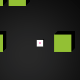

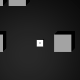

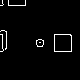

We are doing the updated weight by sampling on batch
TIMESTEP:75641 STATE:training ACTION_TYPE:Random EPSILON:0.8690013099999774 ACTION:1 REWARD:0.0 Q_MAX:0.0 Loss:0.007785677


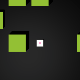

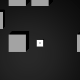

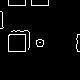

We are doing the updated weight by sampling on batch
TIMESTEP:75642 STATE:training ACTION_TYPE:Random EPSILON:0.8689013109999774 ACTION:2 REWARD:0.0 Q_MAX:0.0 Loss:0.0077983816


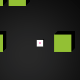

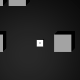

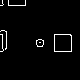

We are doing the updated weight by sampling on batch
TIMESTEP:75643 STATE:training ACTION_TYPE:Max Q EPSILON:0.8688013119999773 ACTION:0 REWARD:0.6 Q_MAX:0.7041047 Loss:0.007978241


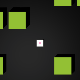

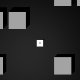

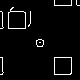

We are doing the updated weight by sampling on batch
TIMESTEP:75644 STATE:training ACTION_TYPE:Random EPSILON:0.8687013129999773 ACTION:0 REWARD:0.7 Q_MAX:0.0 Loss:0.0064716116


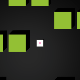

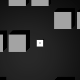

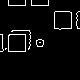

We are doing the updated weight by sampling on batch
TIMESTEP:75645 STATE:training ACTION_TYPE:Random EPSILON:0.8686013139999773 ACTION:1 REWARD:0.20000000000000004 Q_MAX:0.0 Loss:0.006805538


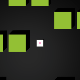

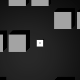

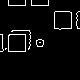

We are doing the updated weight by sampling on batch
TIMESTEP:75646 STATE:training ACTION_TYPE:Random EPSILON:0.8685013149999773 ACTION:3 REWARD:0.10000000000000003 Q_MAX:0.0 Loss:0.008535285


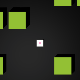

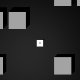

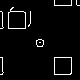

We are doing the updated weight by sampling on batch
TIMESTEP:75647 STATE:training ACTION_TYPE:Random EPSILON:0.8684013159999773 ACTION:2 REWARD:0.1 Q_MAX:0.0 Loss:0.008489007


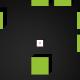

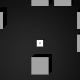

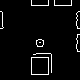

We are doing the updated weight by sampling on batch
TIMESTEP:75648 STATE:training ACTION_TYPE:Random EPSILON:0.8683013169999773 ACTION:3 REWARD:0.0 Q_MAX:0.0 Loss:0.0074411985


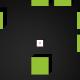

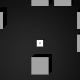

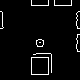

We are doing the updated weight by sampling on batch
TIMESTEP:75649 STATE:training ACTION_TYPE:Random EPSILON:0.8682013179999772 ACTION:1 REWARD:0.1 Q_MAX:0.0 Loss:0.008492235


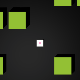

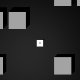

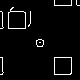

We are doing the updated weight by sampling on batch
TIMESTEP:75650 STATE:training ACTION_TYPE:Random EPSILON:0.8681013189999772 ACTION:0 REWARD:0.7 Q_MAX:0.0 Loss:0.008281263


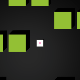

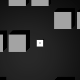

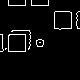

We are doing the updated weight by sampling on batch
TIMESTEP:75651 STATE:training ACTION_TYPE:Random EPSILON:0.8680013199999772 ACTION:3 REWARD:0.10000000000000003 Q_MAX:0.0 Loss:0.01024136


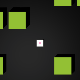

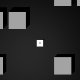

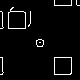

NoSuchWindowException: Message: no such window: window was already closed
  (Session info: chrome=89.0.4389.114)


In [9]:
train_NN(model,game_state,observe=False)
# train_NN(model,game_state,observe=True)

In [ ]:
# image = cv.imread("../screenshot/test.png")
# image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
# image = cv.Canny(image, threshold1 = 100, threshold2 = 200) 
# cv.imwrite("../screenshot/result_test.png", image)
# #     image = image[100:830, 850:1580]
# #     image = image[240:650, 1000:1400] 
# #     image = image[200:700, 950:1450] 
# #     image = cv.resize(image, (80,80))
# #     cv.imwrite(screenshot_80, image) 
# #     image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
# #     cv.imwrite(screenshot_grey, image)
# #     image = cv.Canny(image, threshold1 = 100, threshold2 = 200) 
# #     cv.imwrite(screenshot_canny, image)

In [ ]:
# image = cv.imread('Picture1.png')

# # image = image[200:700, 950:1450] 
# # image = cv.resize(image, (80,80))
# # cv.imwrite(screenshot_80, image) 
# image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
# cv.imwrite('../screenshot/Picture1_grey.png', image)
# image = cv.Canny(image, threshold1 = 100, threshold2 = 200) 
# cv.imwrite('../screenshot/Picture1_canny.png', image)

In [5]:
result = pd.read_csv(episode_file_path)

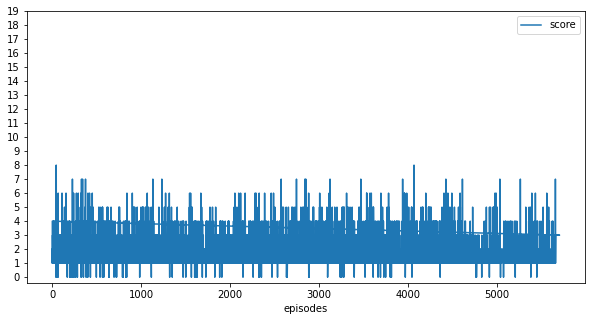

In [6]:
import matplotlib.pyplot as plt
import pandas as pd


result.plot(x='episodes', y='score' ,figsize=(10,5), grid=False)
plt.yticks(np.arange(0, 20, 1))
plt.show()

In [7]:
max(result['score'])

8